In [4]:
import kagglehub
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings("ignore")


In [5]:
path = kagglehub.dataset_download("kartik2112/fraud-detection")
df = pd.read_csv(path+'/fraudTrain.csv')

In [6]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [7]:
from datetime import datetime
for i in (1,2,3, 7,8,9,10,15,21):
  df[df.columns[i]] = df[df.columns[i]].astype('category')

for i in (5,6,17):
  df[df.columns[i]] = df[df.columns[i]].astype('string')



df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'],errors="coerce")
df['dob'] = pd.to_datetime(df['dob'])

In [8]:
df1=df.copy()

Data Anonymization and Feature Removal

In [9]:
df1 = df1.drop(["cc_num","first","last","trans_num"], axis = 1)
df1.head()

,trans_date_trans_time,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,1325376186,38.674999,-78.632459,0


In [11]:
import haversine
from haversine import haversine_vector, Unit
df1["distance"]=0
for i in range (len(df1)):
  df1["distance"][i]=haversine_vector((df1["lat"][i], df1["long"][i]), (df1["merch_lat"][i],df1["merch_long"][i]), unit=Unit.KILOMETERS)
df1["distance"]=np.round(df1["distance"],3)
df1.head()

C:\Users\giovi\AppData\Local\Temp\ipykernel_9284\1469005860.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["distance"][i]=haversine_vector((df1["lat"][i], df1["long"][i]), (df1["merch_lat"][i],df1["merch_long"][i]), unit=Unit.KILOMETERS)


,trans_date_trans_time,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,is_fraud,distance
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,1325376018,36.011293,-82.048315,0,78.598
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1325376044,49.159047,-118.186462,0,30.212
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,1325376051,43.150704,-112.154481,0,108.206
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,1325376076,47.034331,-112.561071,0,95.673
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,1325376186,38.674999,-78.632459,0,77.557


In [12]:
df1=df1.drop(["lat","long","merch_lat","merch_long"],axis=1)

In [13]:
df1["distance"].describe()

count    1.296675e+06
mean     7.611476e+01
std      2.911698e+01
min      2.200000e-02
25%      5.533500e+01
50%      7.823200e+01
75%      9.850300e+01
max      1.521170e+02
Name: distance, dtype: float64

In [14]:
print("trans_date_trans_time:",df1["trans_date_trans_time"][0], "unix_time:",df1["unix_time"][0])
print("trans_date_trans_time:",df1["trans_date_trans_time"][81], "unix_time:",df1["unix_time"][81])
print("Difference between 2 units in trans_date_trans_time:", df1["trans_date_trans_time"][81] - df1["trans_date_trans_time"][0])
print("Difference between 2 units unix time:", df1["unix_time"][81] - df1["unix_time"][0])

trans_date_trans_time: 2019-01-01 00:00:18 unix_time: 1325376018
trans_date_trans_time: 2019-01-01 01:00:19 unix_time: 1325379619
Difference between 2 units in trans_date_trans_time: 0 days 01:00:01
Difference between 2 units unix time: 3601


In [15]:
df1=df1.drop(["unix_time"],axis=1)

In [16]:
df1['age'] = (df1['trans_date_trans_time'] - df1['dob']).dt.days // 365
df1['age'] = df1['age'].astype('int')

In [17]:
df1=df1.drop(["dob"],axis=1)

In [18]:
df1=df1.drop(["zip","street"],axis=1)

In [19]:
df2=df1.copy()

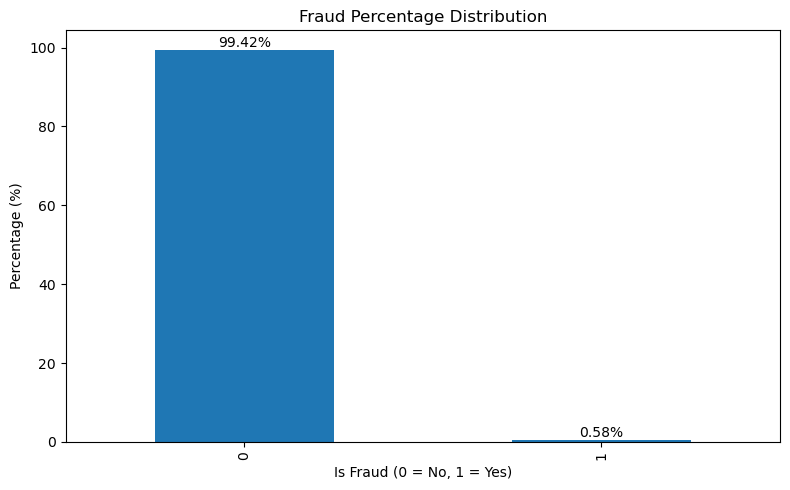

In [20]:
ax = (df2.groupby(["is_fraud"]).size() / len(df2) * 100).plot(kind='bar', figsize=(8, 5))
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{bar.get_height():.2f}%',
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.title('Fraud Percentage Distribution')
plt.xlabel('Is Fraud (0 = No, 1 = Yes)')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

In [21]:
df2.dtypes

trans_date_trans_time    datetime64[ns]
merchant                       category
category                       category
amt                             float64
gender                         category
city                           category
state                          category
city_pop                          int64
job                            category
is_fraud                       category
distance                        float64
age                               int32
dtype: object

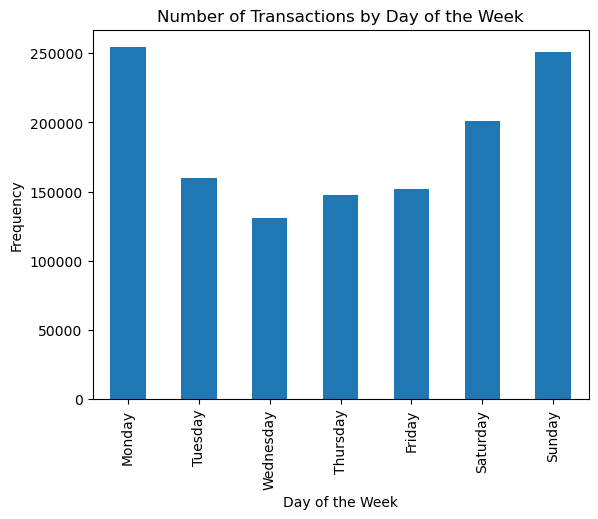

In [22]:
df2['d'] = df2['trans_date_trans_time'].dt.day_name()
df2["d"] = df2["d"].astype("category")
(df2.groupby('d').size()).reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).plot(kind='bar')

plt.title('Number of Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.show()

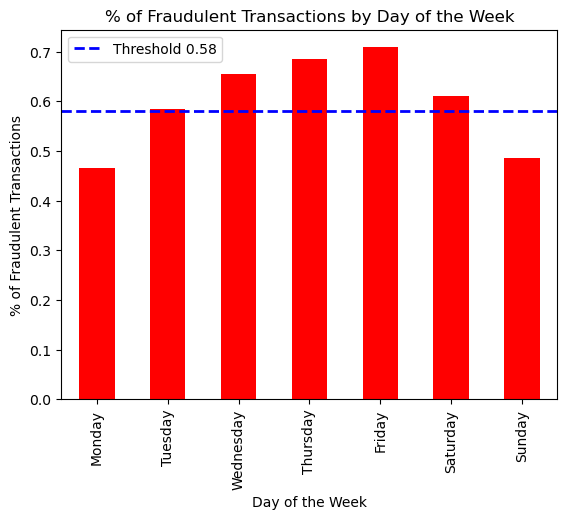

In [23]:
((df2[df2["is_fraud"] == 1].groupby(df2['d']).size() * 100) /(df2.groupby(df2['d']).size())).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind="bar", color="r")
plt.axhline(y=0.58, color="b", linestyle="--", linewidth=2, label="Threshold 0.58")
plt.title('% of Fraudulent Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('% of Fraudulent Transactions')
plt.legend()
plt.show()

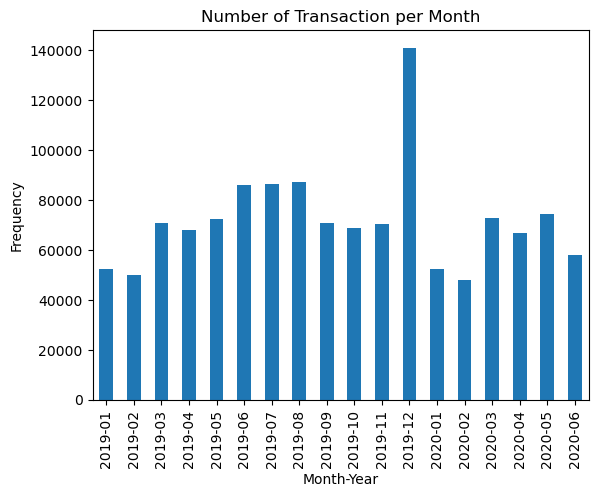

In [24]:
df2['ym'] = df2['trans_date_trans_time'].dt.strftime('%Y-%m')
df2["ym"] = df2["ym"].astype("category")
(df2.groupby('ym').size()).plot(kind ='bar')
plt.title('Number of Transaction per Month')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.show()

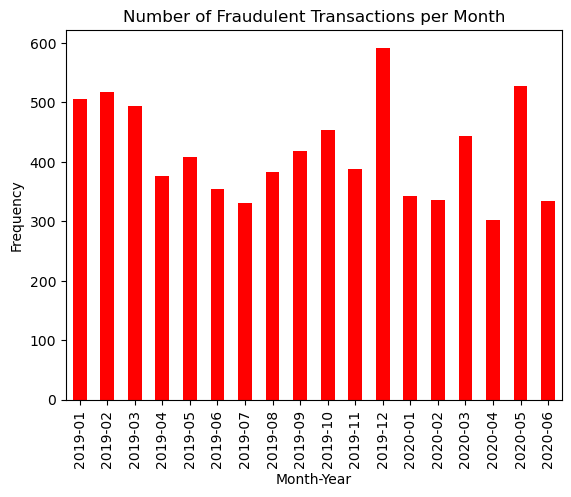

In [25]:
df2[df2["is_fraud"]==1].groupby("ym").size().plot(kind='bar',color="r")
plt.title('Number of Fraudulent Transactions per Month')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.show()

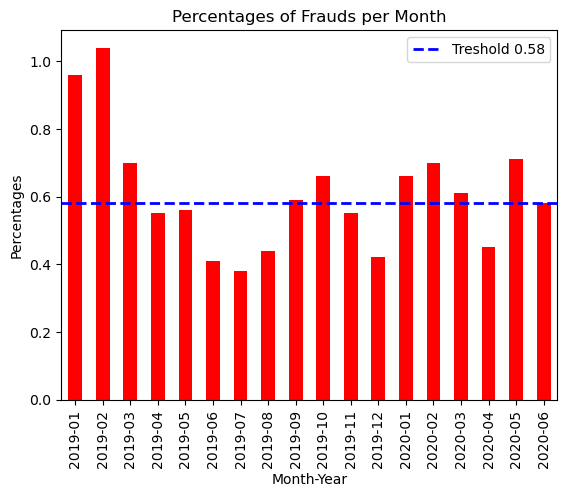

In [26]:
round((df2[df2['is_fraud'] == 1].groupby('ym').size()*100)/df2['is_fraud'].groupby(df2["ym"]).size(),2).plot(kind="bar",color="r")
plt.axhline(y=0.58,color="b",linestyle="--",linewidth=2,label="Treshold 0.58")
plt.title('Percentages of Frauds per Month')
plt.xlabel('Month-Year')
plt.ylabel('Percentages')
plt.legend()
plt.show()

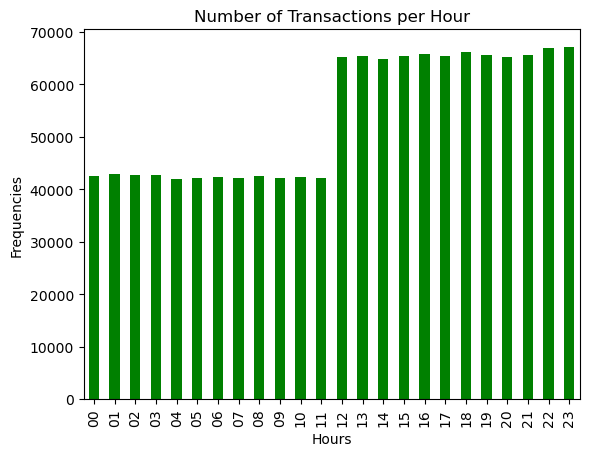

In [27]:
df2['hour'] = df2['trans_date_trans_time'].dt.strftime('%H')
df2["hour"] = df2["hour"].astype("category")
(df2.groupby("hour").size()).plot(kind="bar",color="g")
plt.title('Number of Transactions per Hour')
plt.xlabel('Hours')
plt.ylabel('Frequencies')
plt.show()

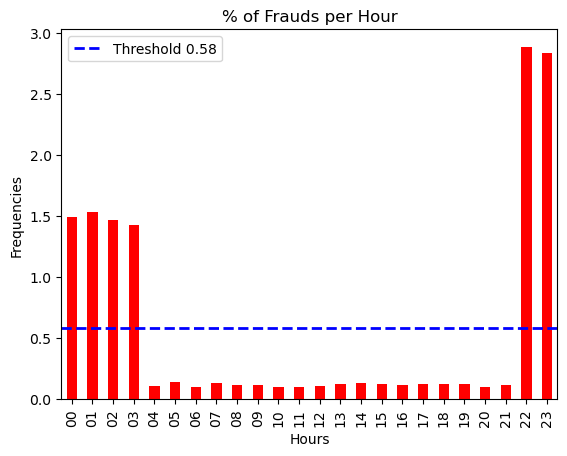

In [28]:
((df2[df2['is_fraud'] == 1].groupby('hour').size()*100)/df2.groupby("hour").size()).plot(kind = 'bar', color = 'r')
plt.axhline(y=0.58,color="b",linestyle="--",linewidth=2, label="Threshold 0.58")
plt.title('% of Frauds per Hour')
plt.xlabel('Hours')
plt.ylabel('Frequencies')
plt.legend()
plt.show()

In [29]:
df1=df1.drop("trans_date_trans_time",axis=1)
df1=pd.merge(df1,df2[["d","ym","hour"]],left_index=True, right_index=True)
df1.dtypes

merchant    category
category    category
amt          float64
gender      category
city        category
state       category
city_pop       int64
job         category
is_fraud    category
distance     float64
age            int32
d           category
ym          category
hour        category
dtype: object

In [30]:
round((df2["category"].value_counts() * 100) / len(df2),2)

category
gas_transport     10.15
grocery_pos        9.54
home               9.49
shopping_pos       9.00
kids_pets          8.72
shopping_net       7.52
entertainment      7.25
food_dining        7.05
personal_care      7.00
health_fitness     6.62
misc_pos           6.14
misc_net           4.88
grocery_net        3.51
travel             3.12
Name: count, dtype: float64

In [31]:
df_percentages = pd.concat([
    (df2["category"].value_counts() * 100) / len(df2),
    (df2[df2['is_fraud'] == 1].groupby('category').size() * 100) / df2.groupby("category").size()]
, axis=1, keys=['% Transaction x Category', '% of Total Frauds x Category']).round(2)

print(df_percentages)

                % Transaction x Category  % of Total Frauds x Category
category                                                              
gas_transport                      10.15                          0.47
grocery_pos                         9.54                          1.41
home                                9.49                          0.16
shopping_pos                        9.00                          0.72
kids_pets                           8.72                          0.21
shopping_net                        7.52                          1.76
entertainment                       7.25                          0.25
food_dining                         7.05                          0.17
personal_care                       7.00                          0.24
health_fitness                      6.62                          0.15
misc_pos                            6.14                          0.31
misc_net                            4.88                          1.45
grocer

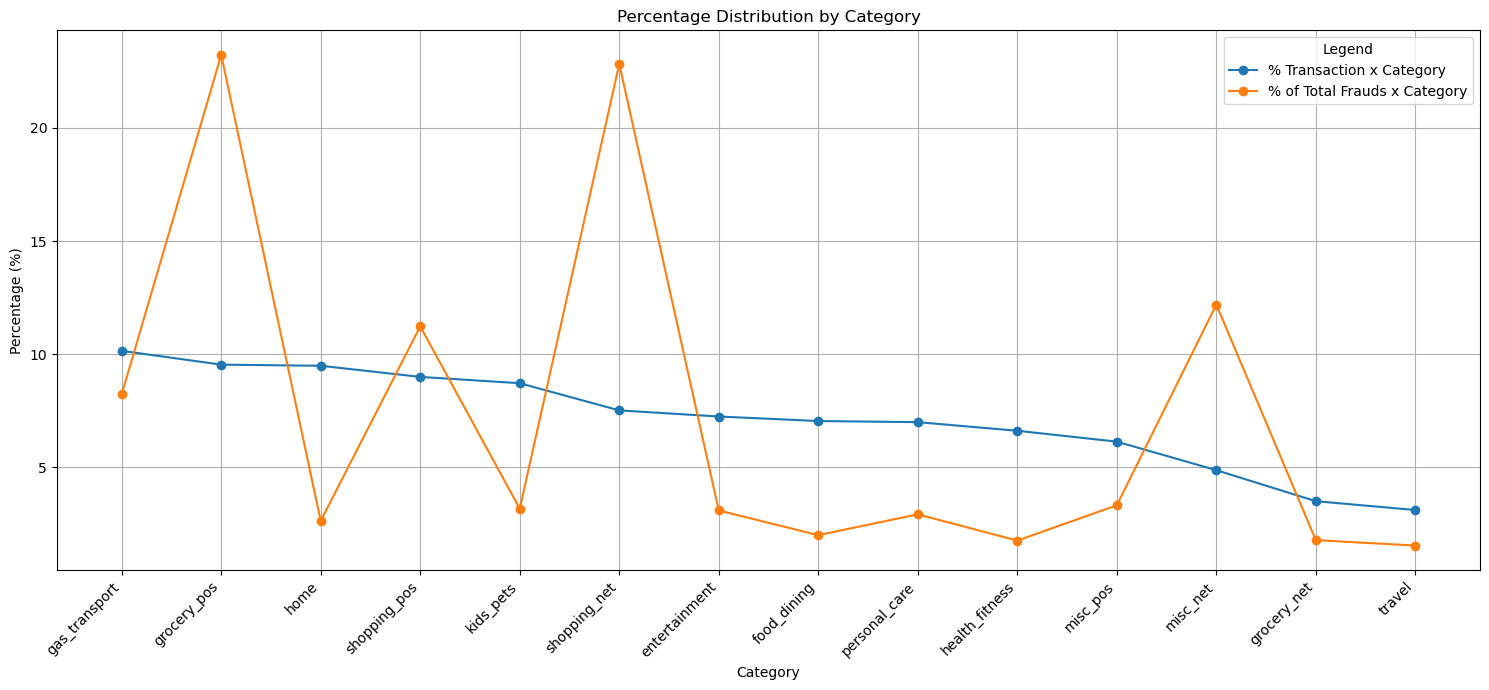

In [32]:
df2_percentages = pd.concat([
    (df2["category"].value_counts() * 100) / len(df),
    (df2[df2['is_fraud'] == 1].groupby('category').size() * 100) / len(df2[df2['is_fraud'] == 1])
], axis=1, keys=['% Transaction x Category', '% of Total Frauds x Category']).round(2)

ax = df2_percentages.plot(kind='line', marker='o', figsize=(15, 7))
plt.title('Percentage Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')
ax.set_xticks(range(len(df2_percentages)))
ax.set_xticklabels(df2_percentages.index, rotation=45, ha="right")
plt.grid(True)
plt.legend(title='Legend')
plt.tight_layout()
plt.show()

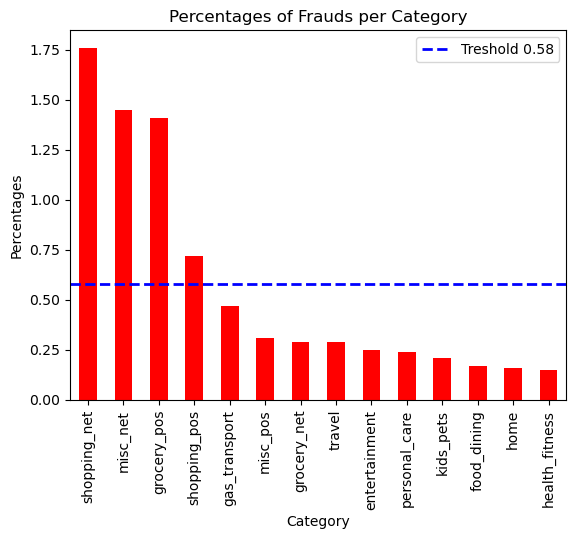

category
shopping_net      1.76
misc_net          1.45
grocery_pos       1.41
shopping_pos      0.72
gas_transport     0.47
misc_pos          0.31
grocery_net       0.29
travel            0.29
entertainment     0.25
personal_care     0.24
kids_pets         0.21
food_dining       0.17
home              0.16
health_fitness    0.15
dtype: float64


In [33]:
tab=round((df1[df1['is_fraud'] == 1].groupby('category').size() * 100) / df1.groupby('category').size(),2).sort_values(ascending=False)
ax=(round((df2[df2['is_fraud'] == 1].groupby('category').size() * 100) / df2.groupby('category').size(),2).sort_values(ascending=False)).plot(kind='bar',color="r")
plt.title('Percentages of Frauds per Category')
plt.xlabel('Category')
plt.ylabel('Percentages')
plt.axhline(y=0.58,linestyle="--",color="b",linewidth=2,label="Treshold 0.58")
plt.legend()
plt.show()
plt.show()
print(tab)

Text(0.5, 1.0, '% Fraudelent Transactions per Category - % Fraudulent Transactions in the Whole Dataset')

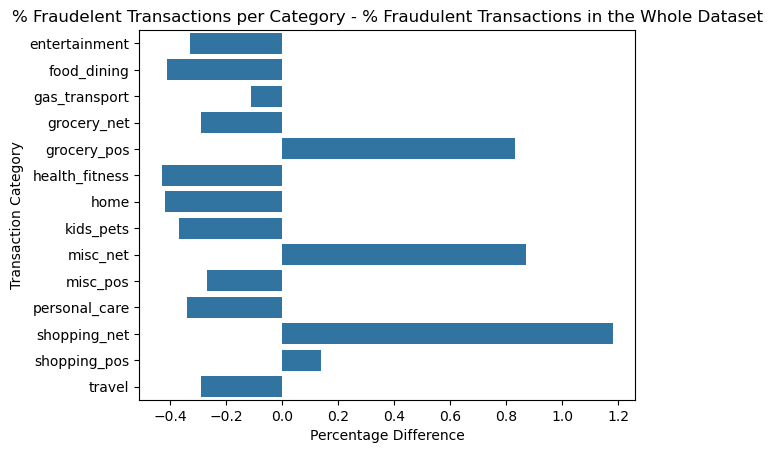

In [34]:
import seaborn as sns
c = 0.58
a=round((df2[df2['is_fraud'] == 1].groupby('category').size() * 100) / df2.groupby('category').size(),2).sort_values(ascending=False)
b=a-c
b_df = b.reset_index()
b_df.columns = ['category', 'difference']
ax=sns.barplot(y='category',x='difference',data=b_df.sort_values('difference',ascending=False))
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('% Fraudelent Transactions per Category - % Fraudulent Transactions in the Whole Dataset')

In [35]:
df2_percentages = pd.concat([
    (df2['gender'].value_counts()*100)/len(df2),
    (df2[df2['is_fraud'] == 1].groupby('gender').size() * 100) / len(df2[df2['is_fraud'] == 1])
], axis=1, keys=['% Gender Distribution', '% of Frauds for each Gender']).round(2)

print(df2_percentages)

        % Gender Distribution  % of Frauds for each Gender
gender                                                    
F                       54.74                        49.76
M                       45.26                        50.24


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, 'AK'),
  Text(1, 0, 'AL'),
  Text(2, 0, 'AR'),
  Text(3, 0, 'AZ'),
  Text(4, 0, 'CA'),
  Text(5, 0, 'CO'),
  Text(6, 0, 'CT'),
  Text(7, 0, 'DC'),
  Text(8, 0, 'DE'),
  Text(9, 0, 'FL'),
  Text(10, 0, 'GA'),
  Text(11, 0, 'HI'),
  Text(12, 0, 'IA'),
  Text(13, 0, 'ID'),
  Text(14, 0, 'IL'),
  Text(15, 0, 'IN'),
  Text(16, 0, 'KS'),
  Text(17, 0, 'KY'),
  Text(18, 0, 'LA'),
  Text(19, 0, 'MA'),
  Text(20, 0, 'MD'),
  Text(21, 0, 'ME'),
  Text(22, 0, 'MI'),
  Text(23, 0, 'MN'),
  Text(24, 0, 'MO'),
  Text(25, 0, 'MS'),
  Text(26, 0, 'MT'),
  Text(27, 0, 'NC'),
  Text(28, 0, 'ND'),
  Text(29, 0, 'NE'),
  Text(30, 0, 'NH'),
  Text(31, 0, 'NJ'),
  Text(32, 0, 'NM'),
  Text(33, 0, 'NV'),
  Text(34, 0, 'NY'),
  Text(35, 0, 'OH'),
  Text(36, 0, 'OK'),
  T

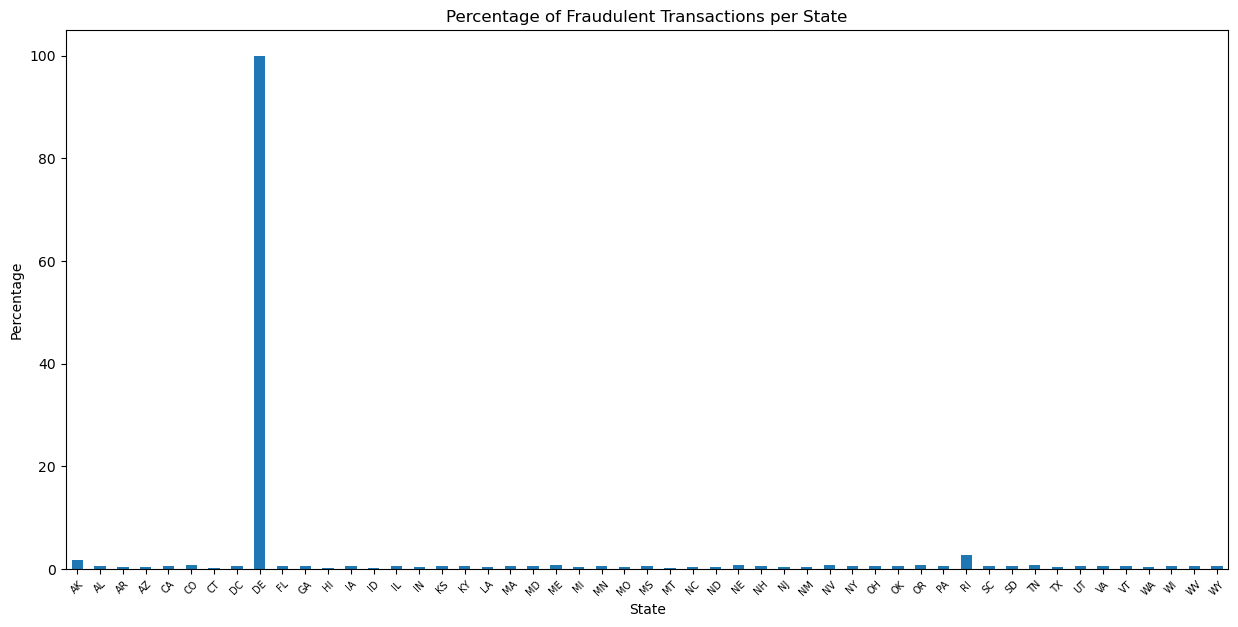

In [36]:
ax=((df2[df2['is_fraud'] == 1].groupby('state').size() * 100) / df2.groupby('state').size()).plot(kind="bar",figsize=(15,7))
plt.title("Percentage of Fraudulent Transactions per State")
plt.xlabel("State")
plt.ylabel("Percentage")
plt.xticks(rotation=45, fontsize=7)

In [37]:
df[df["state"]=="DE"].head(100)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
233631,2019-04-28 00:41:37,6011826317034777,fraud_Schamberger-O'Keefe,grocery_pos,294.91,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,8f85e701f609911b99bea627eb71aa49,1335573697,38.166715,-75.023367,1
233744,2019-04-28 01:49:28,6011826317034777,fraud_Kuphal-Predovic,misc_net,868.29,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,8c941f2849ccac44d32ef08ea784fc67,1335577768,38.910900,-74.856625,1
233826,2019-04-28 02:33:09,6011826317034777,fraud_Goodwin-Nitzsche,grocery_pos,280.26,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,0fc1109cb9a10961595e79736ccc1293,1335580389,38.523208,-74.460889,1
234625,2019-04-28 10:24:34,6011826317034777,"fraud_Huel, Hammes and Witting",grocery_pos,296.25,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,b4248cfc8b44fec6193767918d49b334,1335608674,38.593896,-76.031493,1
236522,2019-04-28 23:03:24,6011826317034777,fraud_Waters-Cruickshank,health_fitness,20.58,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,567ed9b2d7d10ad519cdd697cd338f70,1335654204,39.003922,-75.852152,1
236643,2019-04-28 23:41:43,6011826317034777,fraud_Cormier LLC,shopping_net,1012.77,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,00d158609d7ac753da792e9d0eb88a0b,1335656503,39.596186,-75.559281,1
237095,2019-04-29 03:29:41,6011826317034777,fraud_Ruecker Group,misc_net,885.96,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,e0613e4142b2d05867299832ac453e01,1335670181,39.666374,-76.358642,1
237740,2019-04-29 10:13:47,6011826317034777,fraud_Smitham-Schiller,grocery_net,10.93,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,788a8fea8199a4e8a6a47ffab824e571,1335694427,37.691598,-76.058416,1
239854,2019-04-29 23:51:22,6011826317034777,"fraud_Baumbach, Feeney and Morar",shopping_net,960.49,Christine,Johnson,F,9612 Robert Light Apt. 340,Georgetown,DE,19947,38.679,-75.3932,18799,"Designer, multimedia",2000-03-16,4193b953223a1c9432f9d3c380e67be9,1335743482,39.073319,-75.545153,1


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, 'AK'),
  Text(1, 0, 'AL'),
  Text(2, 0, 'AR'),
  Text(3, 0, 'AZ'),
  Text(4, 0, 'CA'),
  Text(5, 0, 'CO'),
  Text(6, 0, 'CT'),
  Text(7, 0, 'DC'),
  Text(8, 0, 'DE'),
  Text(9, 0, 'FL'),
  Text(10, 0, 'GA'),
  Text(11, 0, 'HI'),
  Text(12, 0, 'IA'),
  Text(13, 0, 'ID'),
  Text(14, 0, 'IL'),
  Text(15, 0, 'IN'),
  Text(16, 0, 'KS'),
  Text(17, 0, 'KY'),
  Text(18, 0, 'LA'),
  Text(19, 0, 'MA'),
  Text(20, 0, 'MD'),
  Text(21, 0, 'ME'),
  Text(22, 0, 'MI'),
  Text(23, 0, 'MN'),
  Text(24, 0, 'MO'),
  Text(25, 0, 'MS'),
  Text(26, 0, 'MT'),
  Text(27, 0, 'NC'),
  Text(28, 0, 'ND'),
  Text(29, 0, 'NE'),
  Text(30, 0, 'NH'),
  Text(31, 0, 'NJ'),
  Text(32, 0, 'NM'),
  Text(33, 0, 'NV'),
  Text(34, 0, 'NY'),
  Text(35, 0, 'OH'),
  Text(36, 0, 'OK'),
  T

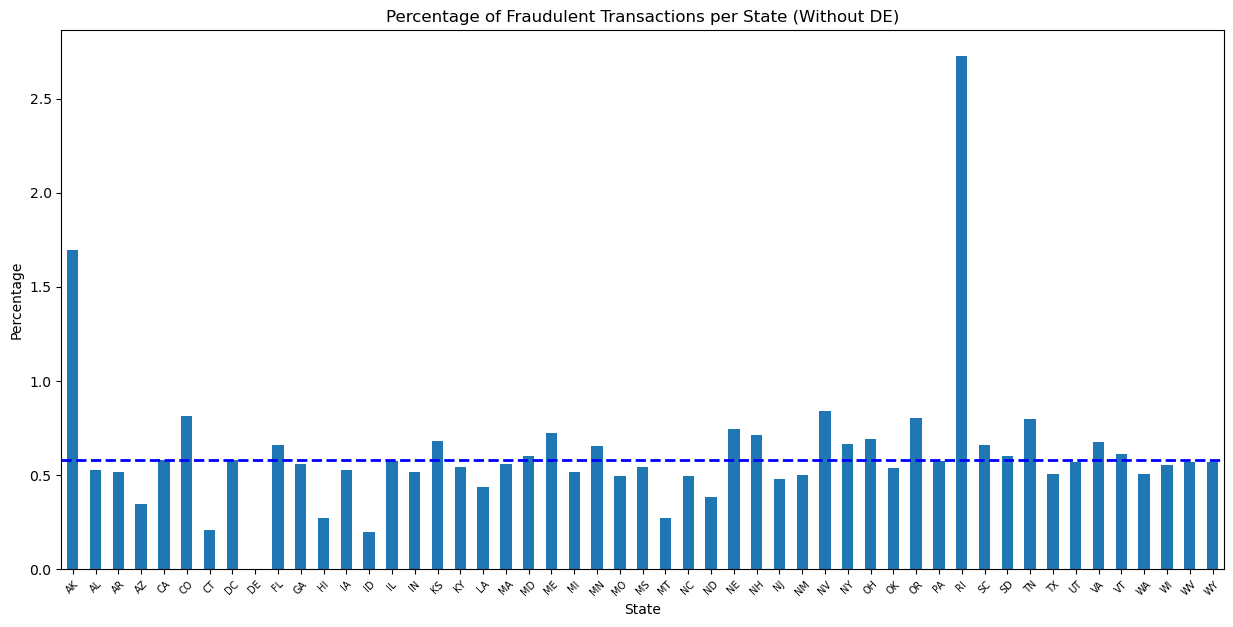

In [38]:
df2bis=df2[df2["state"]!="DE"]
ax=((df2bis[df2bis['is_fraud'] == 1].groupby('state').size() * 100) / df2bis.groupby('state').size()).plot(kind="bar",figsize=(15,7))
plt.axhline(y=0.58,color="b",linestyle="--",linewidth=2,label="Treshold 0.58")
plt.title("Percentage of Fraudulent Transactions per State (Without DE)")
plt.xlabel("State")
plt.ylabel("Percentage")
plt.xticks(rotation=45, fontsize=7)

In [39]:
df1[["job","merchant","city"]].describe()

,job,merchant,city
count,1296675,1296675,1296675
unique,494,693,894
top,Film/video editor,fraud_Kilback LLC,Birmingham
freq,9779,4403,5617


In [40]:
dfnum=df1[['amt',"city_pop","age","distance","is_fraud"]]

In [41]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = dfnum.corr()
corr.style.background_gradient(cmap='coolwarm')

,amt,city_pop,age,distance,is_fraud
amt,1.000000,0.005818,-0.009753,-0.001085,0.219404
city_pop,0.005818,1.000000,-0.092451,0.010901,0.002136
age,-0.009753,-0.092451,1.000000,-0.004592,0.012244
distance,-0.001085,0.010901,-0.004592,1.000000,0.000403
is_fraud,0.219404,0.002136,0.012244,0.000403,1.000000


In [42]:
df2["age"].describe()

count    1.296675e+06
mean     4.552822e+01
std      1.740895e+01
min      1.300000e+01
25%      3.200000e+01
50%      4.400000e+01
75%      5.700000e+01
max      9.500000e+01
Name: age, dtype: float64

Text(0, 0.5, 'Percentage')

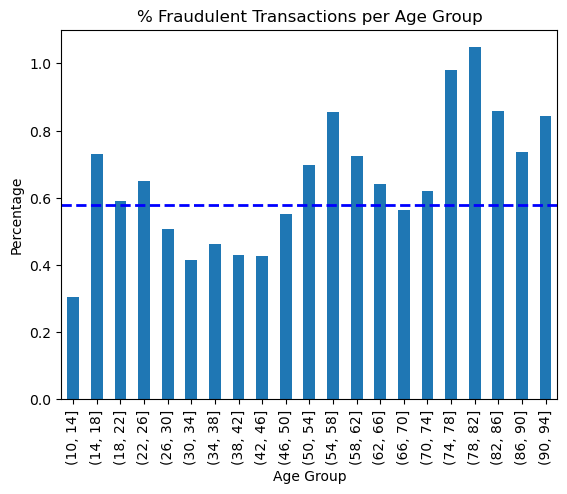

In [43]:
bins=[i for i in range (10,96,4)]
df2["age2"]=pd.cut(df2["age"],bins=bins)
ax=((df2[df2["is_fraud"]==1].groupby("age2").size()*100)/df2.groupby("age2").size()).plot(kind="bar")
plt.axhline(y=0.58, color="blue", linestyle="--", linewidth=2, label="Threshold 0.58")
plt.title("% Fraudulent Transactions per Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage")

In [44]:
df2["distance"].describe()

count    1.296675e+06
mean     7.611476e+01
std      2.911698e+01
min      2.200000e-02
25%      5.533500e+01
50%      7.823200e+01
75%      9.850300e+01
max      1.521170e+02
Name: distance, dtype: float64

Text(0, 0.5, 'Frequency')

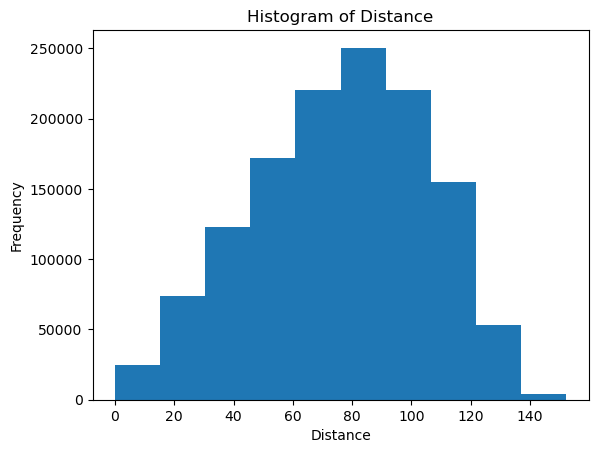

In [45]:
ax=df2["distance"].plot(kind="hist")
plt.title("Histogram of Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")

distance
(0, 10]       0.50
(10, 20]      0.53
(20, 30]      0.55
(30, 40]      0.57
(40, 50]      0.57
(50, 60]      0.60
(60, 70]      0.61
(70, 80]      0.59
(80, 90]      0.57
(90, 100]     0.58
(100, 110]    0.58
(110, 120]    0.58
(120, 130]    0.57
(130, 140]    0.53
(140, 150]    0.62
(150, 160]    0.00
dtype: float64


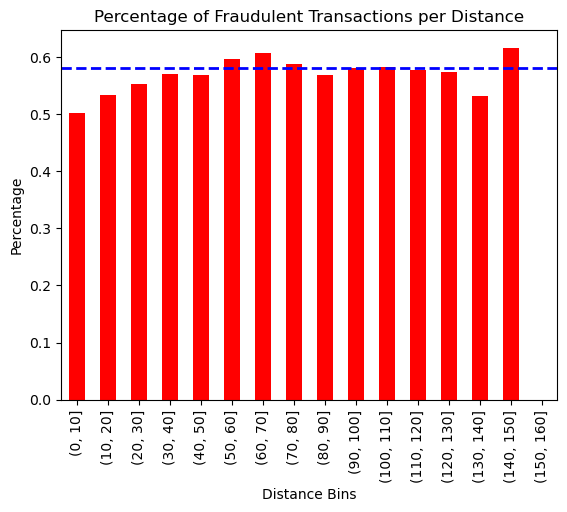

In [46]:
bins=[i for i in range (0,161,10)]
df2["distance"]=pd.cut(df2["distance"],bins=bins)
df2["distance"] = df2["distance"].astype('category')
ax=((df2[df2["is_fraud"]==1].groupby("distance").size()*100)/df2.groupby("distance").size()).plot(kind="bar",color="r")
plt.axhline(y=0.58, color="blue", linestyle="--", linewidth=2, label="Threshold 0.58")
plt.title("Percentage of Fraudulent Transactions per Distance")
plt.xlabel("Distance Bins")
plt.ylabel("Percentage")
print(round((df2[df2["is_fraud"]==1].groupby("distance").size()*100)/df2.groupby("distance").size(),2))
plt.show()

In [47]:
df2["amt"].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [48]:
df2["amt_bins"] = pd.qcut(df2["amt"], q=20, duplicates='drop')
df_percentages = pd.concat([
    df2["amt_bins"].value_counts(sort=False),
    ((df2["amt_bins"].value_counts(sort=False) * 100) / len(df2)),
    (round(df2[df2["is_fraud"] == 1].groupby("amt_bins").size() * 100 /
           df2.groupby("amt_bins").size(), 2))
], axis=1, keys=['Transactions x Bins', "% Transactions x Bins", '% Frauds x Bin']).round(2)
print(df_percentages)

                   Transactions x Bins  % Transactions x Bins  % Frauds x Bin
amt_bins                                                                     
(0.999, 2.44]                    64868                   5.00            0.01
(2.44, 4.11]                     64927                   5.01            0.02
(4.11, 5.9]                      64983                   5.01            0.02
(5.9, 7.75]                      64901                   5.01            0.22
(7.75, 9.65]                     64646                   4.99            0.44
(9.65, 15.74]                    64751                   4.99            0.66
(15.74, 23.74]                   64816                   5.00            0.98
(23.74, 32.13]                   64814                   5.00            0.05
(32.13, 40.14]                   64819                   5.00            0.00
(40.14, 47.52]                   64887                   5.00            0.01
(47.52, 54.15]                   64802                   5.00   

In [49]:
bins=[i for i in range(0, 1000,100)]+ [float('inf')]
df2["amt_bins"]=pd.cut(df2["amt"],bins=bins,right=False)
df_percentages = pd.concat([
    df2["amt_bins"].value_counts(sort=False),
    ((df2["amt_bins"].value_counts(sort=False)*100)/len(df2)),
    (round(df2[df2["is_fraud"]==1].groupby("amt_bins").size()*100/df2.groupby("amt_bins").size(),2))
], axis=1, keys=['Transactions x Bins',"% Transactions x Bins" ,'% of Frauds x Bin']).round(2)
print(df_percentages)

                Transactions x Bins  % Transactions x Bins  % of Frauds x Bin
amt_bins                                                                     
[0.0, 100.0)                1061728                  81.88               0.16
[100.0, 200.0)               173017                  13.34               0.09
[200.0, 300.0)                31631                   2.44               2.51
[300.0, 400.0)                 8600                   0.66              13.49
[400.0, 500.0)                 6068                   0.47               1.66
[500.0, 600.0)                 4558                   0.35               2.06
[600.0, 700.0)                 1945                   0.15               8.59
[700.0, 800.0)                 1910                   0.15              34.71
[800.0, 900.0)                 1679                   0.13              49.49
[900.0, inf)                   5539                   0.43              34.18


In [50]:
bins=[i for i in range(0, 201,200)]+ [float('inf')]
df2["amt_bins"]=pd.cut(df2["amt"],bins=bins,right=False)
df_percentages = pd.concat([
    ((df2["amt_bins"].value_counts(sort=False)*100)/len(df2)),
    (round(df2[df2["is_fraud"]==1].groupby("amt_bins").size()*100/df2.groupby("amt_bins").size(),2)),
    (round(df2[df2["is_fraud"]==1].groupby("amt_bins").size()*100/len(df2[df2['is_fraud'] == 1]),2))
], axis=1, keys=['% Transaction of Dataset', '% of Frauds x Bin',"% of Total Frauds"]).round(2)
print(df_percentages)

              % Transaction of Dataset  % of Frauds x Bin  % of Total Frauds
amt_bins                                                                    
[0.0, 200.0)                     95.22               0.15              24.01
[200.0, inf)                      4.78               9.21              75.99


In [51]:
df2["city_pop"].describe()

count    1.296675e+06
mean     8.882444e+04
std      3.019564e+05
min      2.300000e+01
25%      7.430000e+02
50%      2.456000e+03
75%      2.032800e+04
max      2.906700e+06
Name: city_pop, dtype: float64

In [52]:
df2=df1.copy()

In [53]:
df2["city_bins"] = pd.qcut(df2["city_pop"], q=15)
transactions_per_bin = df2["city_bins"].value_counts(sort=False)
percent_transactions_per_bin = (transactions_per_bin * 100 / len(df2)).round(2)
fraud_percent_per_bin = (
    (df2[df2["is_fraud"] == 1].groupby("city_bins").size() * 100 / df2.groupby("city_bins").size())
    .fillna(0)
    .round(2)
)

df_percentages = pd.concat([
    transactions_per_bin,
    percent_transactions_per_bin,
    fraud_percent_per_bin
], axis=1, keys=['Transactions x Bin', '%Transactions x Bin', '% Frauds x Bin']).round(2)

print(df_percentages)


                       Transactions x Bin  %Transactions x Bin  % Frauds x Bin
city_bins                                                                     
(22.999, 184.0]                     87965                 6.78            0.62
(184.0, 337.0]                      85534                 6.60            0.61
(337.0, 566.0]                      85976                 6.63            0.55
(566.0, 804.0]                      87084                 6.72            0.52
(804.0, 1178.0]                     86199                 6.65            0.56
(1178.0, 1631.0]                    87388                 6.74            0.55
(1631.0, 2092.0]                    85359                 6.58            0.54
(2092.0, 3202.0]                    87469                 6.75            0.56
(3202.0, 4680.0]                    85291                 6.58            0.61
(4680.0, 6841.0]                    86735                 6.69            0.51
(6841.0, 17867.0]                   86705           

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '(22.999, 184.0]'),
  Text(1, 0, '(184.0, 337.0]'),
  Text(2, 0, '(337.0, 566.0]'),
  Text(3, 0, '(566.0, 804.0]'),
  Text(4, 0, '(804.0, 1178.0]'),
  Text(5, 0, '(1178.0, 1631.0]'),
  Text(6, 0, '(1631.0, 2092.0]'),
  Text(7, 0, '(2092.0, 3202.0]'),
  Text(8, 0, '(3202.0, 4680.0]'),
  Text(9, 0, '(4680.0, 6841.0]'),
  Text(10, 0, '(6841.0, 17867.0]'),
  Text(11, 0, '(17867.0, 42384.0]'),
  Text(12, 0, '(42384.0, 105638.0]'),
  Text(13, 0, '(105638.0, 333497.0]'),
  Text(14, 0, '(333497.0, 2906700.0]')])

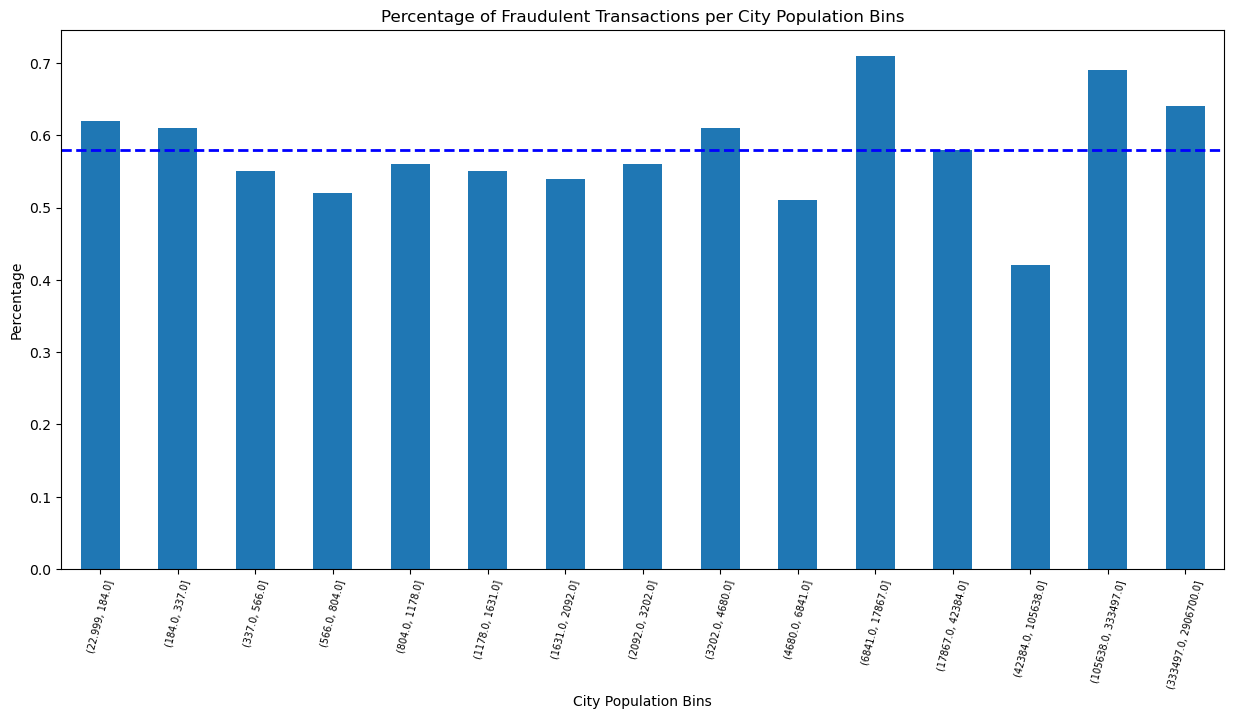

In [54]:
df_percentages['% Frauds x Bin'].plot(kind="bar",figsize=(15,7))
plt.axhline(y=0.58, color="blue", linestyle="--", linewidth=2, label="Threshold 0.58")
plt.title("Percentage of Fraudulent Transactions per City Population Bins")
plt.xlabel("City Population Bins")
plt.ylabel("Percentage")
plt.xticks(rotation=75, fontsize=7)

In [55]:
dftest = pd.read_csv(path+'/fraudTest.csv')
dftest = dftest.drop(['Unnamed: 0'], axis = 1)
dftest.dtypes

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [56]:
for i in (1,2,3, 7,8,9,10,15,21):
  dftest[dftest.columns[i]] = dftest[dftest.columns[i]].astype('category')

for i in (5,6,17):
  dftest[dftest.columns[i]] = dftest[dftest.columns[i]].astype('string')

dftest['trans_date_trans_time'] = pd.to_datetime(dftest['trans_date_trans_time'],errors="coerce")
dftest['dob'] = pd.to_datetime(dftest['dob'])

In [57]:
dftest = dftest.drop(["cc_num","first","last","trans_num"], axis = 1)

from haversine import haversine_vector, Unit
dftest["distance"]=0
for i in range (len(dftest)):
  dftest["distance"][i]=haversine_vector((dftest["lat"][i], dftest["long"][i]), (dftest["merch_lat"][i],dftest["merch_long"][i]), unit=Unit.KILOMETERS)
dftest["distance"]=np.round(dftest["distance"],3)

dftest=dftest.drop(["lat","long","merch_lat","merch_long"],axis=1)

dftest=dftest.drop(["unix_time"],axis=1)

dftest['age'] = (dftest['trans_date_trans_time'] - dftest['dob']).dt.days // 365
dftest['age'] = dftest['age'].astype('int')

dftest=dftest.drop(["dob"],axis=1)

dftest=dftest.drop(["zip","street"],axis=1)

dftest['d'] = dftest['trans_date_trans_time'].dt.day_name()
dftest["d"] = dftest["d"].astype("category")

dftest['ym'] = dftest['trans_date_trans_time'].dt.strftime('%Y-%m')
dftest["ym"] = dftest["ym"].astype("category")

dftest['hour'] = dftest['trans_date_trans_time'].dt.strftime('%H')
dftest["hour"] = dftest["hour"].astype("category")

dftest=dftest.drop(["trans_date_trans_time"],axis=1)

C:\Users\giovi\AppData\Local\Temp\ipykernel_9284\72075080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest["distance"][i]=haversine_vector((dftest["lat"][i], dftest["long"][i]), (dftest["merch_lat"][i],dftest["merch_long"][i]), unit=Unit.KILOMETERS)


In [58]:
X_test = dftest.drop('is_fraud', axis=1)
y_test = dftest['is_fraud']
X_train = df1.drop('is_fraud', axis=1)
y_train = df1['is_fraud']

In [59]:
print(X_train["ym"].value_counts())
print(X_test["ym"].value_counts())

ym
2019-12    141060
2019-08     87359
2019-07     86596
2019-06     86064
2020-05     74343
2020-03     72850
2019-05     72532
2019-03     70939
2019-09     70652
2019-11     70421
2019-10     68758
2019-04     68078
2020-04     66892
2020-06     57747
2019-01     52525
2020-01     52202
2019-02     49866
2020-02     47791
Name: count, dtype: int64
ym
2020-12    139538
2020-08     88759
2020-07     85848
2020-11     72635
2020-09     69533
2020-10     69348
2020-06     30058
Name: count, dtype: int64


In [60]:
set(X_train["state"].unique())-set(X_test["state"].unique())

{'DE'}

In [61]:
X_train["state"].unique()

['NC', 'WA', 'ID', 'MT', 'VA', ..., 'AK', 'ND', 'CT', 'RI', 'DE']
Length: 51
Categories (51, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

In [62]:
X_test["ym"].value_counts()

ym
2020-12    139538
2020-08     88759
2020-07     85848
2020-11     72635
2020-09     69533
2020-10     69348
2020-06     30058
Name: count, dtype: int64

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(df1["is_fraud"].value_counts())
print(y_train_resampled.value_counts())

is_fraud
0    1289169
1       7506
Name: count, dtype: int64
is_fraud
0    7506
1    7506
Name: count, dtype: int64


In [64]:
EDAX_train_res=X_train_resampled[["d","ym","hour","category","state","gender","age","amt"]]
EDAX_train_res.dtypes

d           category
ym          category
hour        category
category    category
state       category
gender      category
age            int32
amt          float64
dtype: object

In [65]:
EDAX_test=X_test[["d","ym","hour","category","state","gender","age","amt"]]

In [66]:
EDAX_test["ym"].value_counts()

ym
2020-12    139538
2020-08     88759
2020-07     85848
2020-11     72635
2020-09     69533
2020-10     69348
2020-06     30058
Name: count, dtype: int64

In [67]:
EDAX_test1=EDAX_test.copy()
EDAX_train_res1=EDAX_train_res.copy()
EDAX_test1["ym"]= [s[5:] for s in EDAX_test1["ym"]]
EDAX_train_res1["ym"]= [s[5:] for s in EDAX_train_res1["ym"]]
EDAX_train_res1= pd.get_dummies(EDAX_train_res1, columns=['d',"ym","hour","category","state","gender"], drop_first=False)
EDAX_test1= pd.get_dummies(EDAX_test1, columns=['d',"ym","hour","category","state","gender"], drop_first=False)

In [68]:
EDAX_train_res1=EDAX_train_res1.drop(["state_DE"],axis=1)
EDAX_test1["ym_01"]=0
EDAX_test1["ym_02"]=0
EDAX_test1["ym_03"]=0
EDAX_test1["ym_04"]=0
EDAX_test1["ym_05"]=0

In [69]:
EDAX_test1=EDAX_test1[EDAX_train_res1.columns]

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
EDAX_train_res1scaled= scaler.fit_transform(EDAX_train_res1)
EDAX_test1scaled = scaler.transform(EDAX_test1)

In [71]:
from sklearn.linear_model import LogisticRegression
logreg1= LogisticRegression(random_state=1, max_iter=1000, solver='lbfgs')
logreg1.fit(EDAX_train_res1scaled, y_train_resampled)
y_pred1=logreg1.predict(EDAX_test1scaled)

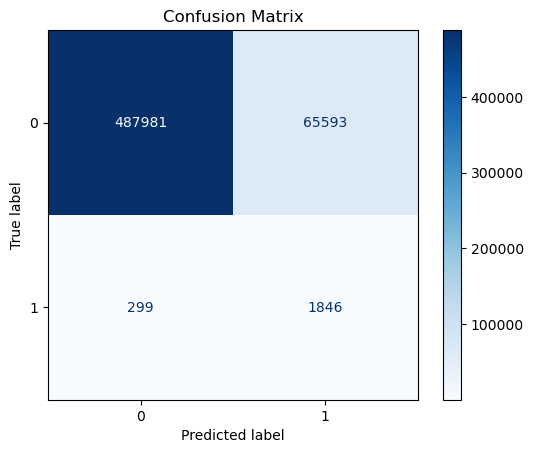

In [72]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg1.classes_)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()

0:	learn: 0.9427376	total: 195ms	remaining: 1m 37s
100:	learn: 0.9863760	total: 3.97s	remaining: 15.7s
200:	learn: 0.9919585	total: 9.26s	remaining: 13.8s
300:	learn: 0.9948159	total: 15s	remaining: 9.94s
400:	learn: 0.9964749	total: 19.5s	remaining: 4.81s
499:	learn: 0.9977376	total: 24.4s	remaining: 0us


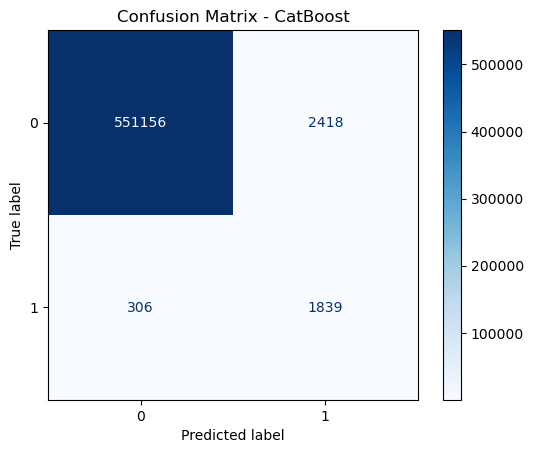

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.43      0.86      0.57      2145

    accuracy                           1.00    555719
   macro avg       0.72      0.93      0.79    555719
weighted avg       1.00      1.00      1.00    555719



In [73]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
categorical_features = ['d', 'ym', 'hour',"category","state","gender"]

catboost_model1 = CatBoostClassifier(
    iterations=500,         
    learning_rate=0.1,      
    depth=6,                
    random_seed=1,          
    verbose=100,            
    eval_metric='F1',       
)

catboost_model1.fit(
    EDAX_train_res,         
    y_train_resampled,      
    cat_features=categorical_features  
)

y_pred2 = catboost_model1.predict(EDAX_test)

cm = confusion_matrix(y_test, y_pred2)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model1.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CatBoost')
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred2))


c:\Users\giovi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\giovi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\giovi\anaconda3\Lib\site-packages\catboost\core.py", line 5201, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\giovi\anaconda3\Lib\site-packages\catboost\core.py", line 2381, 

Best Parameters Found:  {'l2_leaf_reg': 4, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 300, 'rsm': 0.7}


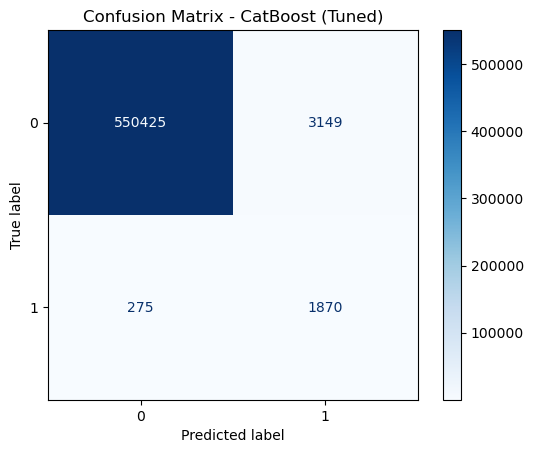

In [74]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import parallel_backend
import matplotlib.pyplot as plt
from scipy.stats import randint

param_dist = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.15],
    "max_depth": randint(4, 6),                
    "n_estimators": [200, 300, 400],          
    "l2_leaf_reg": [1, 2, 3, 4],              
    "rsm": [0.5, 0.7, 0.9, 1, 1.1],          
}

model = CatBoostClassifier(
    random_seed=1,      
    cat_features=['d', 'ym', 'hour', "category", "state", "gender"],  
    verbose=0           
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

with parallel_backend('threading', n_jobs=-1):
    rscv2 = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        scoring='f1',  
        cv=cv,
        n_iter=20,     
        random_state=1
    )
    rscv2.fit(EDAX_train_res, y_train_resampled)


print("Best Parameters Found: ", rscv2.best_params_)


best_model = rscv2.best_estimator_
best_model.fit(EDAX_train_res, y_train_resampled)
y_pred4 = best_model.predict(EDAX_test)

cm = confusion_matrix(y_test, y_pred4)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CatBoost (Tuned)')
plt.show()


Performing RandomizedSearchCV for Hyperparameter Tuning...


c:\Users\giovi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\giovi\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\giovi\anaconda3\Lib\site-packages\catboost\core.py", line 5201, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\giovi\anaconda3\Lib\site-packages\catboost\core.py", line 2374, in

Best Parameters Found:  {'l2_leaf_reg': 3, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 350, 'rsm': 0.7}


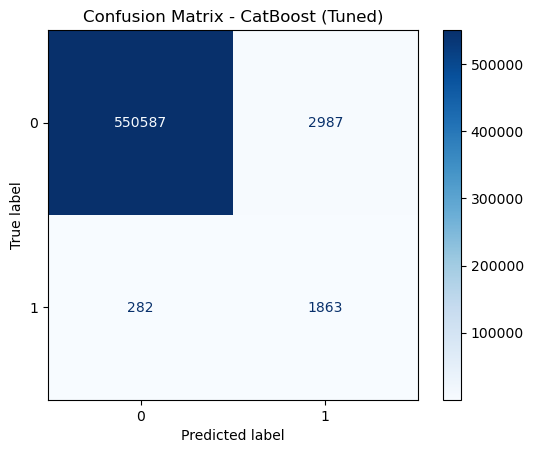

In [75]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import parallel_backend
import matplotlib.pyplot as plt
from scipy.stats import randint

param_dist = {
    "learning_rate": [0.1, 0.12, 0.15, 0.18], 
    "max_depth": randint(4, 7),               
    "n_estimators": [250, 300, 350],          
    "l2_leaf_reg": [3, 4, 5, 6],              
    "rsm": [0.6, 0.7, 0.8],                   
}


model = CatBoostClassifier(
    random_seed=1,      
    cat_features=['d', 'ym', 'hour', "category", "state", "gender"],  
    verbose=0           
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)


print("Performing RandomizedSearchCV for Hyperparameter Tuning...")
with parallel_backend('threading', n_jobs=-1):
    rscv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        scoring='f1',  
        cv=cv,
        n_iter=20,     
        random_state=1
    )
    rscv.fit(EDAX_train_res, y_train_resampled)

print("Best Parameters Found: ", rscv.best_params_)

best_model2 = rscv.best_estimator_
best_model2.fit(EDAX_train_res, y_train_resampled)

y_pred5 = best_model2.predict(EDAX_test)

cm = confusion_matrix(y_test, y_pred5)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model2.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CatBoost (Tuned)')
plt.show()



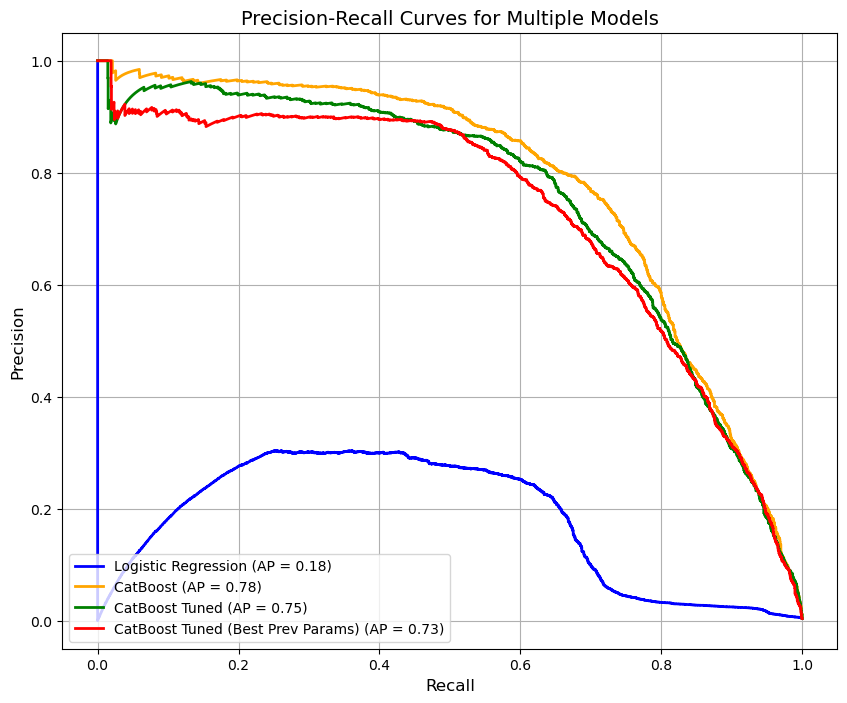

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob1 = logreg1.predict_proba(EDAX_test1scaled)[:, 1]
precision1, recall1, _ = precision_recall_curve(y_test, y_prob1)
average_precision1 = average_precision_score(y_test, y_prob1)

y_prob2 = catboost_model1.predict_proba(EDAX_test)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, y_prob2)
average_precision2 = average_precision_score(y_test, y_prob2)

y_prob4 = best_model.predict_proba(EDAX_test)[:, 1]
precision4, recall4, _ = precision_recall_curve(y_test, y_prob4)
average_precision4 = average_precision_score(y_test, y_prob4)

y_prob5 = best_model2.predict_proba(EDAX_test)[:, 1]
precision5, recall5, _ = precision_recall_curve(y_test, y_prob5)
average_precision5 = average_precision_score(y_test, y_prob5)

plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1, label=f'Logistic Regression (AP = {average_precision1:.2f})', color='blue', linewidth=2)
plt.plot(recall2, precision2, label=f'CatBoost (AP = {average_precision2:.2f})', color='orange', linewidth=2)
plt.plot(recall4, precision4, label=f'CatBoost Tuned (AP = {average_precision4:.2f})', color='green', linewidth=2)
plt.plot(recall5, precision5, label=f'CatBoost Tuned (Best Prev Params) (AP = {average_precision5:.2f})', color='red', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves for Multiple Models', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.show()


In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier

final_params = {
    "learning_rate": 0.15,
    "max_depth": 5,
    "n_estimators": 300,
    "l2_leaf_reg": 4,
    "rsm": 0.7,
    "cat_features": ['d', 'ym', 'hour', "category", "state", "gender"],
    "verbose": 0
}

results = []

for i in range(10):  
    rus = RandomUnderSampler(random_state=None)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    EDAX_train_res = X_train_resampled[["d", "ym", "hour", "category", "state", "gender", "age", "amt"]]
    EDAX_test = X_test[["d", "ym", "hour", "category", "state", "gender", "age", "amt"]]

    model = CatBoostClassifier(**final_params)
    model.fit(EDAX_train_res, y_train_resampled)
    y_pred = model.predict(EDAX_test)
   
    report = classification_report(y_test, y_pred, output_dict=True)
    if '1' in report:  
        results.append({
            "Iteration": i + 1,
            "Class": 1,
            "Recall": report['1']['recall'],
            "Precision": report['1']['precision']
        })

results_df = pd.DataFrame(results)

mean_recall = results_df['Recall'].mean()
mean_precision = results_df['Precision'].mean()

summary = pd.DataFrame([{
    "Iteration": "Overall",
    "Class": 1,
    "Recall": mean_recall,
    "Precision": mean_precision
}])

results_df = pd.concat([results_df, summary], ignore_index=True)
print(results_df)

   Iteration  F1-Score    Recall
0          1  0.996194  0.995559
1          2  0.996615  0.996178
2          3  0.995649  0.994749
3          4  0.995526  0.994641
4          5  0.996502  0.996025
5          6  0.996484  0.995973
6          7  0.996837  0.996480
7          8  0.996208  0.995566
8          9  0.995906  0.995111
9         10  0.994238  0.992491
